In [ ]:
  import os
# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/path/PotholeDetection.zip'

In [ ]:
import zipfile

# Destination directory to unzip the files
extract_dir = '/content/path/PotholeDetection'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List files to verify
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))

/content/path/PotholeDetection/README.roboflow.txt
/content/path/PotholeDetection/README.dataset.txt
/content/path/PotholeDetection/data.yaml
/content/path/PotholeDetection/test/labels/img-244_jpg.rf.1e0637bc48b908c81c25fca45c1af35c.txt
/content/path/PotholeDetection/test/labels/159_png_jpg.rf.fabcfa7b3de0b97892e32ee397affd57.txt
/content/path/PotholeDetection/test/labels/418_png_jpg.rf.4b94e4e0bf15b362f8b0993e5e52daf4.txt
/content/path/PotholeDetection/test/labels/205_png_jpg.rf.002ef030070b2599a5daaa29890f5b02.txt
/content/path/PotholeDetection/test/labels/img-520_jpg.rf.de05298b5f9841a16941ad50828eeb5b.txt
/content/path/PotholeDetection/test/labels/img-20_jpg.rf.e1e84982abc868fe9c59533c9b4f7716.txt
/content/path/PotholeDetection/test/labels/img-515_jpg.rf.bbab8ed11c1708e12e91c6d7d98de61a.txt
/content/path/PotholeDetection/test/labels/img-597_jpg.rf.f300e44270e3eb1b625b367eff24c0bd.txt
/content/path/PotholeDetection/test/labels/788_png_jpg.rf.19c87be2cb22b4627a8d53f9895f9545.txt
/con

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
from PIL import Image
import torch
from torch import nn
import random

In [ ]:
train_img_dir = '/content/path/PotholeDetection/train/images'
train_images = os.listdir(train_img_dir)

val_img_dir = '/content/path/PotholeDetection/valid/images'
val_images = os.listdir(val_img_dir)

train_labels_dir = '/content/path/PotholeDetection/train/labels'
val_labels_dir = '/content/path/PotholeDetection/valid/labels'

In [ ]:
label_list = ['pothole']

In [ ]:
def label_name(label_class):
    if 0 <= label_class < len(label_list):
        return label_list[label_class]
    else:
        return "none"

def load_labels(images, labels_dir):
    labels = []
    for img in images:
        label_path = os.path.join(labels_dir, img.replace('.jpg', '.txt'))
        try:
            with open(label_path, "r") as file:
                text = file.read().strip()
            if len(text) < 1:
                labels.append('None')
            else:
                labels.append(int(text.split()[0]))
        except FileNotFoundError:
            labels.append('None')
    return labels

train_labels = load_labels(train_images, train_labels_dir)
val_labels = load_labels(val_images, val_labels_dir)

def convert_labels(labels):
    return [int(label) if label != 'None' else -1 for label in labels]

train_labels = convert_labels(train_labels)
val_labels = convert_labels(val_labels)

In [ ]:
df_train = pd.DataFrame({
    'image_path': train_images,
    'label_class': train_labels
})
df_train['label_name'] = df_train['label_class'].apply(label_name)

df_val = pd.DataFrame({
    'image_path': val_images,
    'label_class': val_labels
})
df_val['label_name'] = df_val['label_class'].apply(label_name)


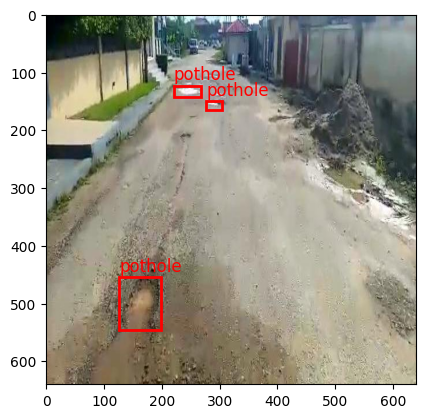

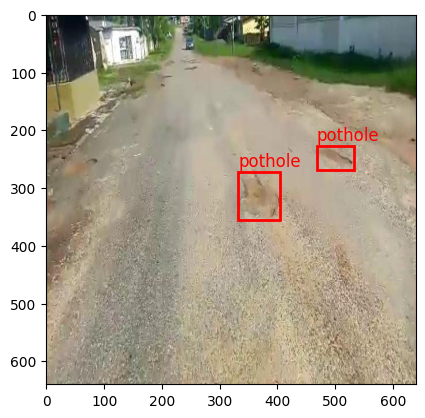

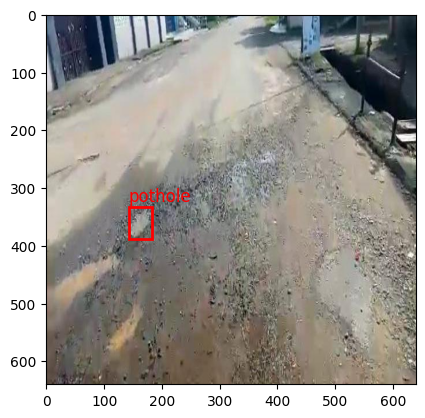

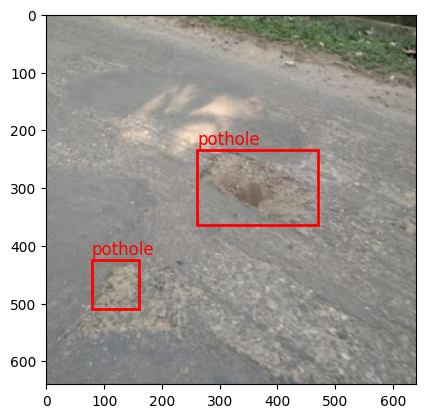

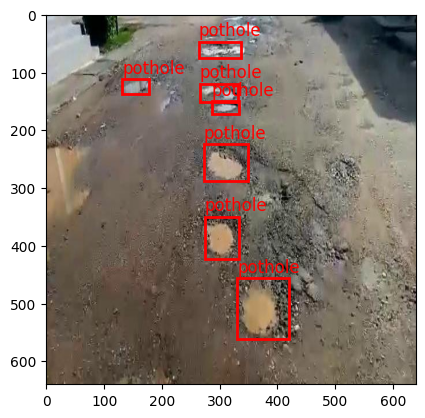

In [ ]:

import matplotlib.patches as patches

def plot_bounding_box(image_path, labels_dir):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_path = os.path.join(labels_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    try:
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.split())
                x_center, y_center, width, height = x_center * img.shape[1], y_center * img.shape[0], width * img.shape[1], height * img.shape[0]
                rect = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x_center - width / 2, y_center - height / 2 - 10, label_name(int(class_id)), color='r', fontsize=12)
    except FileNotFoundError:
        print(f"Label file not found for {image_path}")
    plt.show()


for img_path in df_train['image_path'].sample(5).values:
    plot_bounding_box(os.path.join(train_img_dir, img_path), train_labels_dir)

In [ ]:
!pip install ultralytics
!pip install -U ipywidgets
!pip install wandb


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def _init_(self, kernel_size=7):
        super(SpatialAttention, self)._init_()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class YOLOv9WithAttention(nn.Module):
    def __init__(self, yolo_model):
        super(YOLOv9WithAttention, self).__init__()
        self.backbone = yolo_model.model.model[0]
        self.neck = yolo_model.model.model[1]
        self.head = yolo_model.model.model[2]
        self.spatial_attention = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.backbone(x)
        x = self.spatial_attention(x) * x
        x = self.neck(x)
        x = self.head(x)
        return x

# Load the pre-trained YOLOv9 model
yolo_model = YOLO("yolov9c.pt")

# Integrate the spatial attention module
model_with_attention = YOLOv9WithAttention(yolo_model)
import torch
import torch.nn as nn
from ultralytics import YOLO

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class YOLOv9WithAttention(nn.Module):
    def __init__(self, yolo_model):
        super(YOLOv9WithAttention, self).__init__()
        self.backbone = yolo_model.model.model[0]
        self.neck = yolo_model.model.model[1]
        self.head = yolo_model.model.model[2]
        self.spatial_attention = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.backbone(x)
        x = self.spatial_attention(x) * x
        x = self.neck(x)
        x = self.head(x)
        return x

# Load the pre-trained YOLOv9 model
yolo_model = YOLO("yolov9c.pt")

# Integrate the spatial attention module
model_with_attention = YOLOv9WithAttention(yolo_model)


In [ ]:
trained_weights = "/content/runs/detect/train/weights/best.pt"
model = YOLO(trained_weights)

# Evaluate the model on the validation set
results = model.val(data = '/content/pathhole/pathole/data.yaml')

# Print the evaluation metrics
# Accessing metrics using the appropriate methods
precision = results.box.mp # Mean precision
recall = results.box.mr    # Mean recall
mAP50 = results.box.map50  # mAP@0.5
mAP50_95 = results.box.map  # mAP@0.5:0.95

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP@0.5: {mAP50}")
print(f"mAP@0.5:0.95: {mAP50_95}")


Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25320019 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /content/pathhole/pathole/valid/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


                   all        120        492      0.655      0.512       0.57      0.241
Speed: 0.3ms preprocess, 27.8ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/val
Precision: 0.6546117575688157
Recall: 0.5123457010254555
mAP@0.5: 0.5700521499540929
mAP@0.5:0.95: 0.24126629208085598


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
from PIL import Image
import torch
from torch import nn
import random

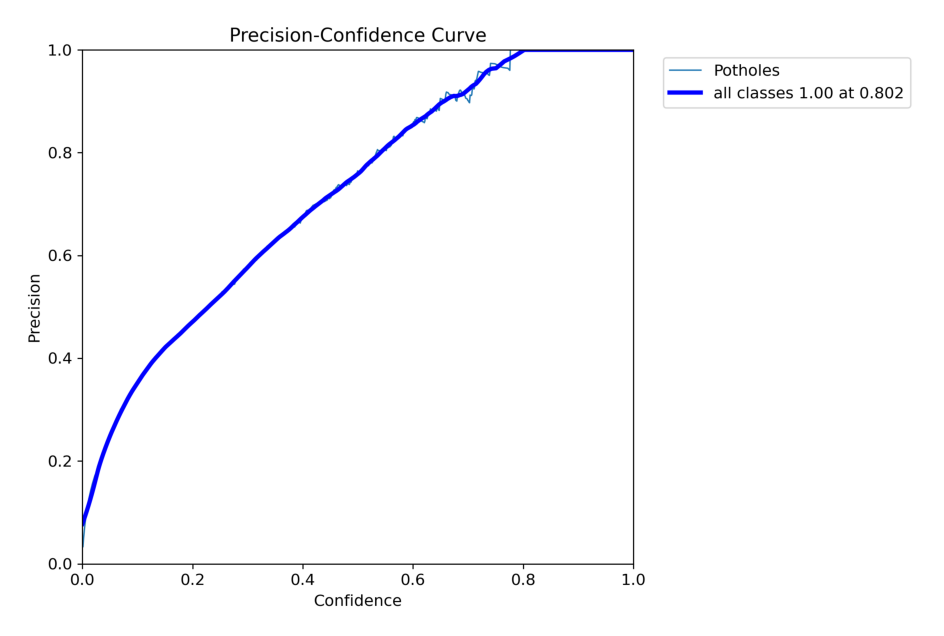

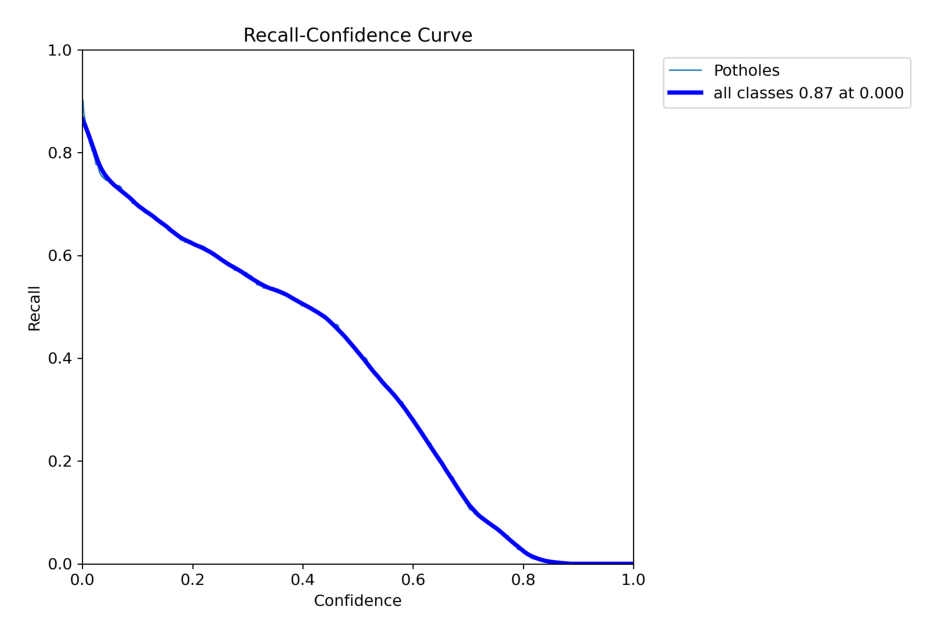

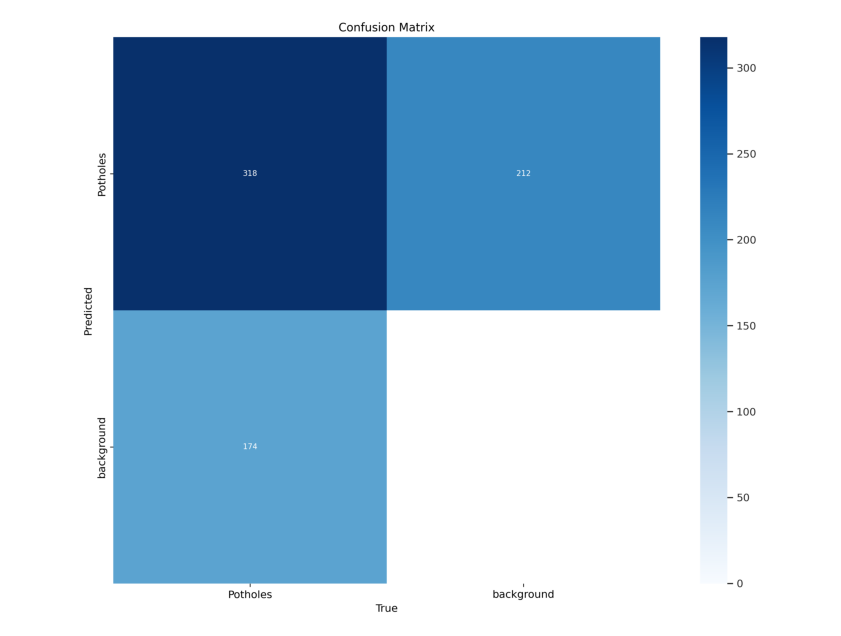

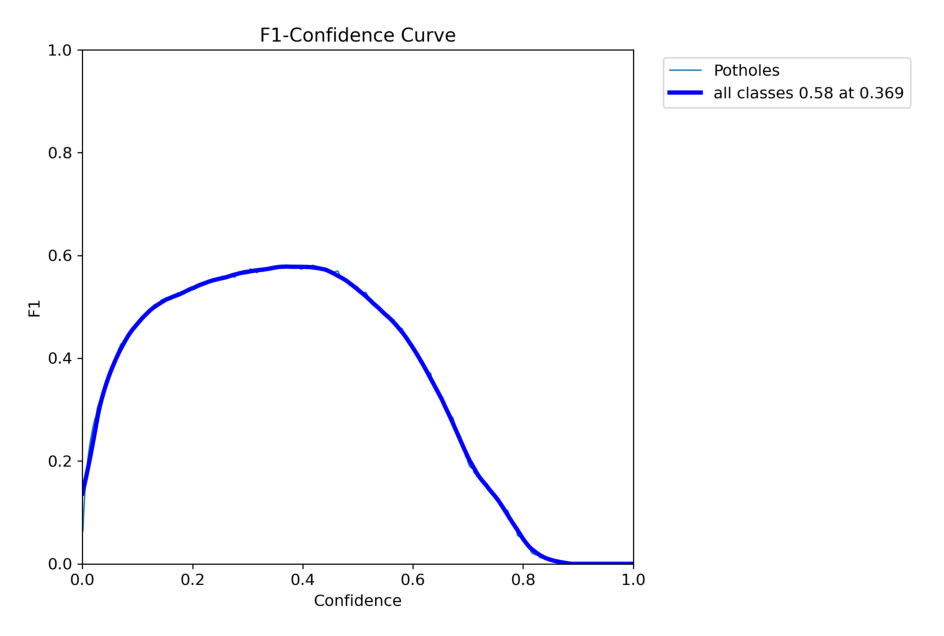

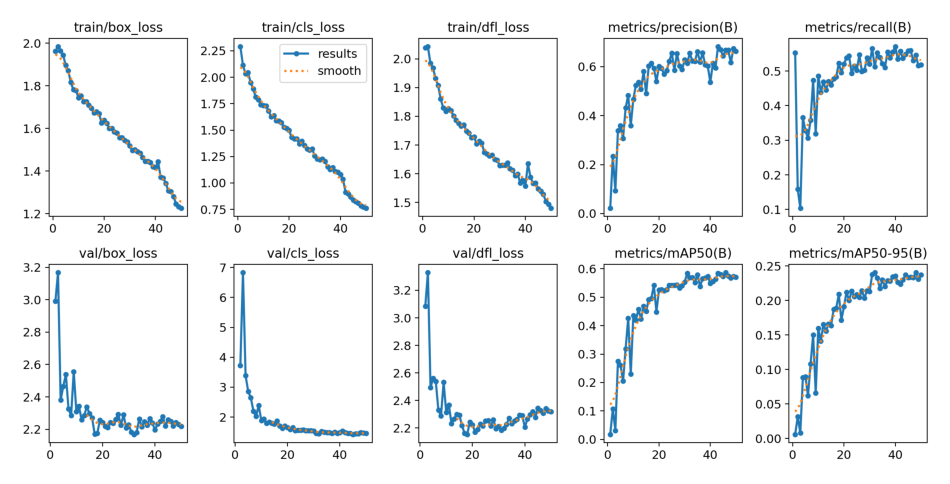

In [ ]:
list_of_metrics = ["P_curve.png", "R_curve.png", "confusion_matrix.png", "F1_curve.png", "results.png"]

for metric in list_of_metrics:
    image = Image.open(f'/content/runs/detect/train/{metric}')
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()


In [ ]:
trained_weights = "/content/runs/detect/train/weights/best.pt"
model = YOLO(trained_weights)

In [ ]:
def test_visualization(images):
    output = model.predict(images)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i, r in enumerate(images):
        ax = axes[i // 3, i % 3]
        im_bgr = cv2.imread(r)
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i, r in enumerate(output):
        ax = axes[i // 3, i % 3]
        im_bgr = r.plot()  # BGR-order numpy array
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)



0: 512x512 5 Potholess, 25.7ms
1: 512x512 2 Potholess, 25.7ms
2: 512x512 2 Potholess, 25.7ms
3: 512x512 3 Potholess, 25.7ms
4: 512x512 9 Potholess, 25.7ms
5: 512x512 6 Potholess, 25.7ms
6: 512x512 4 Potholess, 25.7ms
7: 512x512 2 Potholess, 25.7ms
8: 512x512 4 Potholess, 25.7ms
Speed: 2.7ms preprocess, 25.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)


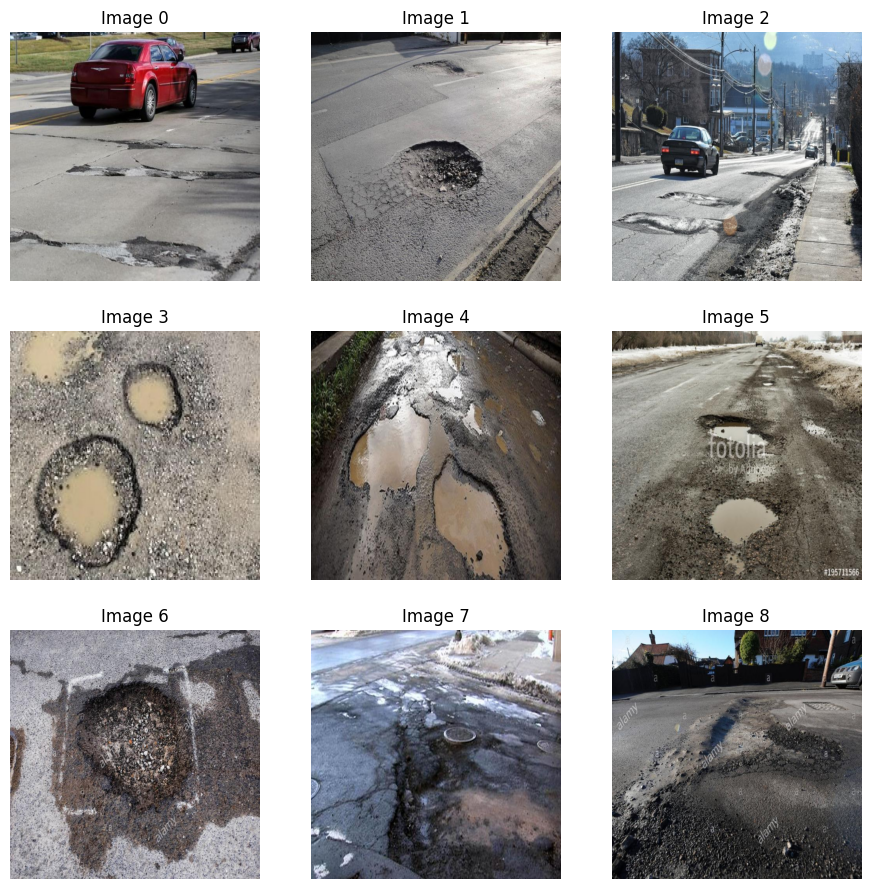

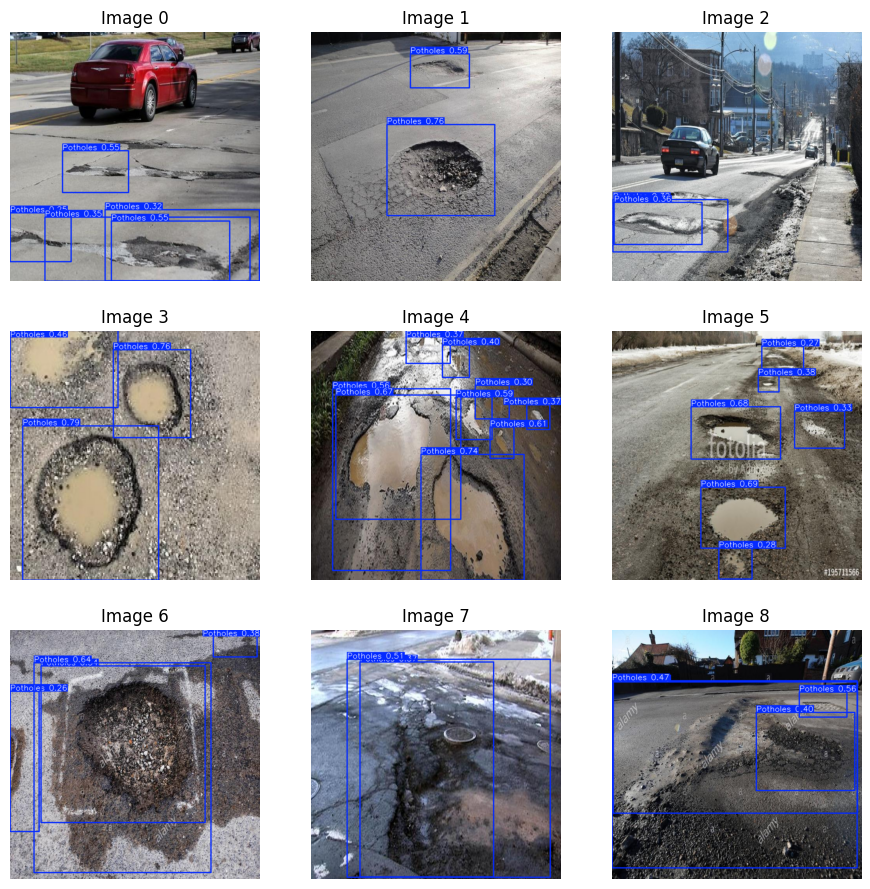

In [ ]:
test_img_dir = '/content/pathhole/pathole/test/images'
test_images = os.listdir(test_img_dir)
test_img = [os.path.join(test_img_dir, img) for img in test_images[:9]]

test_visualization(test_img)